# Import libraries

In [1]:
import numpy as np
import pandas as pd
import os

from numpy.lib.nanfunctions import nanvar
from sympy import bernoulli
from tensorflow.python.keras.saving.saved_model.load import metrics
from torch.ao.quantization.utils import activation_dtype
from triton.language import dtype

2024-10-07 20:57:06.314206: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 20:57:06.648416: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 20:57:07.264935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Read data

In [2]:
DATASET_PATH = 'Dataset'
DATASET_CSV_PATH = f'{DATASET_PATH}/CSV'

In [3]:
LABEL = {
    'Jump': 0,
    'Kick': 1,
    'Punch': 2,
    'Left': 3,
    'Right': 4,
    'Stand': 5
}

In [4]:
X = []
y = []

# Read all files in the dataset
for label in LABEL:
    for file in os.listdir(f'{DATASET_CSV_PATH}/Test/{label}'):
        df = pd.read_csv(f'{DATASET_CSV_PATH}/Test/{label}/{file}', sep=',')
        X.append(df)
        y.append(LABEL[label])
        print(f"Read file: {file}")

Read file: resized_Jump_21.csv
Read file: resized_Jump_16.csv
Read file: resized_Jump_11.csv
Read file: resized_Jump_10.csv
Read file: resized_Jump_22.csv
Read file: resized_Jump_20.csv
Read file: resized_Jump_12.csv
Read file: resized_Jump_9.csv
Read file: resized_Jump_13.csv
Read file: resized_Jump_18.csv
Read file: resized_Jump_14.csv
Read file: resized_Jump_15.csv
Read file: resized_Jump_5.csv
Read file: resized_Jump_23.csv
Read file: resized_Kick_8.csv
Read file: resized_Kick_20.csv
Read file: resized_Kick_16.csv
Read file: resized_Kick_12.csv
Read file: resized_Kick_21.csv
Read file: resized_Kick_23.csv
Read file: resized_Kick_22.csv
Read file: resized_Kick_18.csv
Read file: resized_Kick_10.csv
Read file: resized_Kick_6.csv
Read file: resized_Kick_9.csv
Read file: resized_Kick_2.csv
Read file: resized_Kick_17.csv
Read file: resized_Kick_25.csv
Read file: resized_Kick_15.csv
Read file: resized_Kick_14.csv
Read file: resized_Kick_13.csv
Read file: resized_Kick_24.csv
Read file: res

In [5]:
# Drop first and second columns
for i, element in enumerate(X):
    X[i] = element.drop(element.columns[[0, 1]], axis=1)

In [6]:
X[0].columns

Index(['pose_0', 'pose_1', 'pose_2', 'pose_3', 'pose_4', 'pose_5', 'pose_6',
       'pose_7', 'pose_8', 'pose_9', 'pose_10', 'pose_11', 'pose_12',
       'pose_13', 'pose_14', 'pose_15', 'pose_16', 'pose_17', 'pose_18',
       'pose_19', 'pose_20', 'pose_21', 'pose_22', 'pose_23', 'pose_24',
       'pose_25', 'pose_26', 'pose_27', 'pose_28', 'pose_29', 'pose_30',
       'pose_31', 'pose_32'],
      dtype='object')

In [7]:
for i, element in enumerate(X):
    for column in element.columns:
        X[i][column] = X[i][column].apply(lambda x: np.array(x[1:-1].split(',')).astype(np.float32))

## Convert All Sequences to the Same Length

In [8]:
# Get the maximum length of all sequences
all_dim = []
for i, element in enumerate(X):
    all_dim.append(element.shape[0])
    print(f"Element {i} shape: {np.shape(element)}, label: {y[i]}")

Element 0 shape: (81, 33), label: 0
Element 1 shape: (60, 33), label: 0
Element 2 shape: (64, 33), label: 0
Element 3 shape: (69, 33), label: 0
Element 4 shape: (31, 33), label: 0
Element 5 shape: (31, 33), label: 0
Element 6 shape: (57, 33), label: 0
Element 7 shape: (44, 33), label: 0
Element 8 shape: (84, 33), label: 0
Element 9 shape: (62, 33), label: 0
Element 10 shape: (60, 33), label: 0
Element 11 shape: (63, 33), label: 0
Element 12 shape: (64, 33), label: 0
Element 13 shape: (31, 33), label: 0
Element 14 shape: (31, 33), label: 1
Element 15 shape: (46, 33), label: 1
Element 16 shape: (43, 33), label: 1
Element 17 shape: (31, 33), label: 1
Element 18 shape: (43, 33), label: 1
Element 19 shape: (46, 33), label: 1
Element 20 shape: (24, 33), label: 1
Element 21 shape: (39, 33), label: 1
Element 22 shape: (31, 33), label: 1
Element 23 shape: (31, 33), label: 1
Element 24 shape: (61, 33), label: 1
Element 25 shape: (21, 33), label: 1
Element 26 shape: (48, 33), label: 1
Element 27 

### Handle the Outliers and make the lengths of all sequences the same
Handle different lengths of sequences
    Set the maximum length = 1.5 * IQR + Q3
    
    * Case 1: If e_dim < Max_dim, then increase the length of the sequence by duplicating each row until the length of the sequence is equal to Max_dim
    * Case 2: If e_dim > Max_dim, then truncate randomly the sequence until the length of the sequence is equal to Max_dim
    * Case 3: If e_dim = Max_dim, then keep the sequence as it is

In [9]:
Max_dim = 147

In [10]:
X_test_temp = []

def pad_or_truncate(element, max_dim):
    current_length = element.shape[0]
    if current_length < max_dim:
        # Pad by repeating elements until reaching the desired length
        metric_temp = []
        j = 0
        while len(metric_temp) != max_dim:
            metric_temp.append(element.iloc[j])
            if len(metric_temp) != max_dim:
                metric_temp.append(element.iloc[j])
            j = (j + 1) % current_length  # Cycle through the indices
        return np.array(metric_temp)

    elif current_length > max_dim:
        metrics_temp = []
        # Down sample by taking every nth element
        step = max(4, current_length // (current_length - max_dim))  # Ensure step is at least 4
        j = 0
        while len(metrics_temp) != max_dim:
            metrics_temp.append(element.iloc[j])
            j = (j + step) % current_length  # Cycle through the indices
        return np.array(metrics_temp)
    return element
# Pad all sequences to the same length
for i, element in enumerate(X):
    print(f"Before padding, element {i} shape: {np.shape(element)}")
    padded_element = pad_or_truncate(element, Max_dim)
    X_test_temp.append(padded_element)
    print(f"After padding, element {i} shape: {np.shape(X_test_temp[-1])}")

Before padding, element 0 shape: (81, 33)
After padding, element 0 shape: (147, 33)
Before padding, element 1 shape: (60, 33)
After padding, element 1 shape: (147, 33)
Before padding, element 2 shape: (64, 33)
After padding, element 2 shape: (147, 33)
Before padding, element 3 shape: (69, 33)
After padding, element 3 shape: (147, 33)
Before padding, element 4 shape: (31, 33)
After padding, element 4 shape: (147, 33)
Before padding, element 5 shape: (31, 33)
After padding, element 5 shape: (147, 33)
Before padding, element 6 shape: (57, 33)
After padding, element 6 shape: (147, 33)
Before padding, element 7 shape: (44, 33)
After padding, element 7 shape: (147, 33)
Before padding, element 8 shape: (84, 33)
After padding, element 8 shape: (147, 33)
Before padding, element 9 shape: (62, 33)
After padding, element 9 shape: (147, 33)
Before padding, element 10 shape: (60, 33)
After padding, element 10 shape: (147, 33)
Before padding, element 11 shape: (63, 33)
After padding, element 11 shape

In [11]:
X_test_temp = np.array(X_test_temp)
y_test = np.array(y)

In [12]:
X_test_temp.shape

(70, 147, 33)

In [13]:
X_test = np.full((X_test_temp.shape[0], X_test_temp.shape[1], X_test_temp.shape[2], 3), np.nan, dtype=np.float32)

for i, element in enumerate(X_test_temp):
    for j, row in enumerate(element):
        for k, value in enumerate(row):
            # Check if the value is np.array([nan, nan, nan])
            if np.isnan(value).all():
                X_test_temp[i][j][k] = np.array([np.nan, np.nan, np.nan], dtype=np.float32)
            else:
                X_test_temp[i][j][k] = value
                
            X_test[i][j][k] = X_test_temp[i][j][k][:3]

In [14]:
X_test.shape

(70, 147, 33, 3)

## Handle Fill NaN Values

### Step 1: Compute the variance of each metric for each sequence.

### Step 2: Fill NaN
   * **Case 1**: If `element[i]` doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
   * **Case 2**: If `element[i]` doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
   * **Case 3**: If `element[i]` has values both before and after, then use the nearest previous and posterior elements:
     - For \( k < i < l \):

$$
\text{element}[i] = \text{element}[k] + (\text{element}[l] - \text{element}[k]) \times \frac{i - k}{l - k}
$$


### Step 1: Compute the variance of each metric for each sequence.

In [15]:
X_test.shape

(70, 147, 33, 3)

In [16]:
cnt = 0

In [17]:
np.nanvar(X_test[0][:, 0], axis=0)

array([0.00093794, 0.00486789, 0.07510272], dtype=float32)

In [18]:
variance_metric = np.empty((X_test.shape[0], X_test.shape[2], 3), dtype=np.float32)
variance_metric.shape

(70, 33, 3)

In [19]:
X_test[0][:, 0].shape

(147, 3)

In [20]:
np.nanvar(X_test[1][:, 0], axis=0)

array([5.8654118e-06, 1.4447882e-03, 1.0162714e-02], dtype=float32)

In [21]:
cls_nan = dict()

for i, element in enumerate(X_test):
    sub_variance_metric = np.empty((element.shape[1], 3), dtype=np.float32)
    
    for j in range(element.shape[1]):
        variance = np.array([np.nan, np.nan, np.nan], dtype=np.float32)
        
        # If there are more than 1 non-NaN values, calculate variance
        if np.count_nonzero(~np.isnan(element[:, j])) > 1:
            variance = np.nanvar(element[:, j], axis=0)
            print(variance)
        else:
            if i not in cls_nan:
                cls_nan[i] = []
            cls_nan[i].append(j)
        # convert to list
        sub_variance_metric[j] = variance
    # print(sub_variance_metric)
    variance_metric[i] = sub_variance_metric

[0.00093794 0.00486789 0.07510272]
[0.00091436 0.00482631 0.06770108]
[0.00091618 0.00482303 0.06770153]
[0.00090214 0.0046776  0.06774426]
[0.00088247 0.00480666 0.06753895]
[0.00089023 0.00476711 0.06755751]
[0.00099142 0.00466243 0.06754014]
[0.00082114 0.0046789  0.03452095]
[0.00098808 0.00466937 0.03412702]
[0.00074502 0.00486647 0.05982284]
[0.00088897 0.00479586 0.05991005]
[0.00223952 0.0051125  0.01928099]
[0.00297628 0.00513428 0.01603602]
[0.00790207 0.00685579 0.03097285]
[0.00844861 0.00699982 0.02280999]
[0.01066233 0.00816686 0.0693518 ]
[0.01027813 0.00719558 0.06377059]
[0.01196703 0.00815269 0.08268679]
[0.01187153 0.00761709 0.076688  ]
[0.01076347 0.00822513 0.08504771]
[0.01159196 0.00729668 0.08350106]
[0.00988932 0.00815126 0.07286943]
[0.01083135 0.00707138 0.07328759]
[0.00093744 0.00331897 0.00021089]
[0.00099874 0.00330313 0.00021137]
[0.00140063 0.00421778 0.1318032 ]
[0.00256171 0.00474848 0.14501439]
[0.00092869 0.00433134 0.1411104 ]
[0.00079688 0.004386

In [22]:
variance_metric = np.array([variance_metric], dtype=np.float32)

In [23]:
variance_metric = variance_metric.reshape(variance_metric.shape[1], variance_metric.shape[2], variance_metric.shape[3])

In [24]:
variance_metric.shape

(70, 33, 3)

In [25]:
# convert to cls_nan to pandas dataframe
cls_nan.keys()

dict_keys([])

In [26]:
LABEL

{'Jump': 0, 'Kick': 1, 'Punch': 2, 'Left': 3, 'Right': 4, 'Stand': 5}

### Step 2: Fill NaN
   * **Case 1**: If `element[i]` doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
   * **Case 2**: If `element[i]` doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
   * **Case 3**: If `element[i]` has values both before and after, then use the nearest previous and posterior elements:
     - For \( k < i < l \):

$$
\text{element}[i] = \text{element}[k] + (\text{element}[l] - \text{element}[k]) \times \frac{i - k}{l - k}
$$


In [27]:
X_test.shape

(70, 147, 33, 3)

In [28]:
variance_metric.shape

(70, 33, 3)

In [29]:
# Function to fill NaN values based on the described cases
def fill_nan(element, variance_metric):
    old_value = None
    k = 0
    
    for i in range(element.shape[0]):
        if np.isnan(element[i]).all():
            # Case 1: If element[i] doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
            if old_value is None:
                for l in range(i + 1, element.shape[0]):
                    if not np.isnan(element[l]).all():
                        element[i] = element[l] + abs(i - l) * variance_metric
                        break
            else:
                # Case 2: If element[i] doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
                flat = False
                for l in range(i + 1, element.shape[0]):
                    if not np.isnan(element[l]).all():
                        if l != k:
                            element[i] = old_value + (element[l] - old_value) / ((i - k) / (l - k))
                            flat = True
                            break
                if not flat:
                    # Case 3: If element[i] has values both before and after, then use the nearest previous and posterior elements
                    element[i] = old_value - abs(i - k) * variance_metric
        old_value = element[i]
    return element

In [30]:
X_test_new = np.empty(X_test.shape, dtype=np.float32)
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[2]):
        # print("Shape of element: ", X_train[i][: , j].shape)
        # print("Shape of variance: ", variance_metric[i][j].shape)
        X_test_new[i][: , j] = fill_nan(X_test[i][: , j], variance_metric[i][j])

In [31]:
np.isnan(np.array([np.nan, np.nan, 0])).sum()

2

In [32]:
variance_metric[0][2]

array([0.00091618, 0.00482303, 0.06770153], dtype=float32)

In [33]:
# Drop data with NaN values
drop_index = list(cls_nan.keys())
# Drop data in X_train_new that has index in drop_index
X_train_new = np.delete(X_test_new, drop_index, axis=0)
y_train = np.delete(X_test_new, drop_index, axis=0)

## LSTM model LSTM model

In [34]:
# check gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4214736906434387854
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6565134336
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11285094677052307149
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2024-10-07 20:57:12.484476: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-07 20:57:12.487274: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-07 20:57:12.487352: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional

In [47]:
# Reshape the data
X_test_reshaped = X_test_new.reshape(X_test_new.shape[0], X_test_new.shape[1], X_test_new.shape[2] * X_test_new.shape[3])

In [44]:
# load the model
model = keras.models.load_model('model.h5')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Text(0.5, 80.7222222222222, 'Predicted')

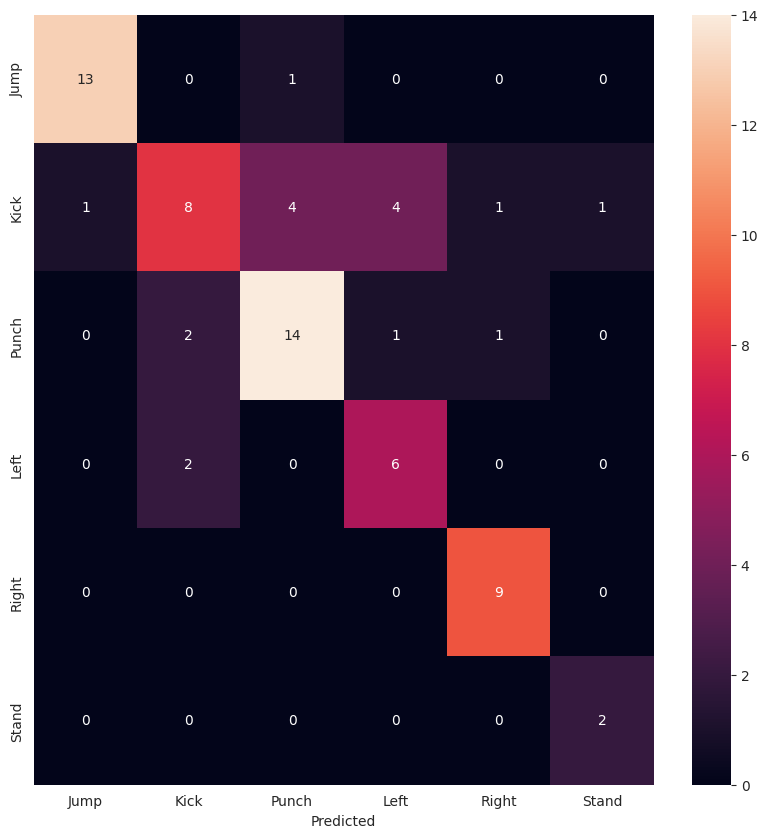

In [48]:
# Show the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred, axis=1)
y_test = y_test[~np.isnan(y_test)]
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=LABEL.keys(), yticklabels=LABEL.keys())
plt.xlabel('Predicted')

In [63]:
LABEL

{'Jump': 0, 'Kick': 1, 'Punch': 2, 'Left': 3, 'Right': 4, 'Stand': 5}

In [50]:
# Show the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=LABEL.keys()))

              precision    recall  f1-score   support

        Jump       0.93      0.93      0.93        14
        Kick       0.67      0.42      0.52        19
       Punch       0.74      0.78      0.76        18
        Left       0.55      0.75      0.63         8
       Right       0.82      1.00      0.90         9
       Stand       0.67      1.00      0.80         2

    accuracy                           0.74        70
   macro avg       0.73      0.81      0.76        70
weighted avg       0.74      0.74      0.73        70
